# Linger : baseline - explore Cell population gene regulatory network
From : https://github.com/Durenlab/LINGER/blob/main/docs/GRN_infer.md#cell-population-gene-regulatory-network

In [1]:
!ls

CECI				PBMCs_tutorial.ipynb  launch_jupyter
LINGER_data			code		      logs
LINGER_output_baseline		data		      scripts
LINGER_output_linger		dry_sub.sh	      sub.sh
Linger_baseline_explorer.ipynb	images		      test_model.pt


## 1. Input Data
- Multi omics matrix (both RNA and ATAC) from [10x genomics](https://cf.10xgenomics.com/samples/cell-arc/1.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5)


In [1]:
import scanpy as sc
import scipy.sparse as sp
import pandas as pd

adata = sc.read_10x_h5('data/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5', gex_only=False)
adata

/opt/conda/envs/LINGER/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 11909 × 144978
    var: 'gene_ids', 'feature_types', 'genome'

In [3]:
matrix = adata.X.T    # linger expects k_features x n_cells
adata.var['gene_ids'] = adata.var.index

# features are genes and peaks grouped together (col1 for gene/peak name and col2 for category: gene or peak)
features = pd.DataFrame(adata.var['gene_ids'].values.tolist(),columns=[1])
features[2] = adata.var['feature_types'].values

barcodes = pd.DataFrame(adata.obs_names,columns=[0])
label = pd.read_csv('data/PBMC_label.txt',sep='\t',header=0)

from LingerGRN.preprocess import *
adata_RNA, adata_ATAC = get_adata(matrix,features,barcodes,label)     # adata_RNA and adata_ATAC are scRNA and scATAC

/opt/conda/envs/LINGER/lib/python3.10/site-packages/LingerGRN/preprocess.py:278: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_RNA.obs['label']=label.loc[adata_RNA.obs['barcode']]['label'].values
/opt/conda/envs/LINGER/lib/python3.10/site-packages/LingerGRN/preprocess.py:281: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ATAC.obs['label']=label.loc[adata_ATAC.obs['barcode']]['label'].values


## 2. adata_RNA & adata_ATAC
From 1. we get two matrices : 
- `adata_RNA` (cells x genes)
- `adata_ATAC` (cells x peaks)

In [41]:
adata_RNA

View of AnnData object with n_obs × n_vars = 9543 × 36601
    obs: 'barcode', 'sample', 'label', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [42]:
adata_ATAC

View of AnnData object with n_obs × n_vars = 9543 × 108377
    obs: 'barcode', 'sample', 'label'
    var: 'gene_ids'

## 3. Preprocess - Pseudobulking - Training
[Skipped part]

## 4. Explore output files

In [47]:
import pandas as pd
method = "baseline"

### 4.1 Cell population gene regulatory network

#### 4.1.1 TF binding potential (TF-RE)

In [48]:
tf_re = pd.read_csv(f"LINGER_output_{method}/cell_population_TF_RE_binding.txt", sep="\t", index_col=0)
tf_re.shape    # regions x TFs

(97042, 451)

In [49]:
# Sparsity
(tf_re == 0).mean().mean()

0.8419419831064073

In [50]:
tf_re.head(3)

,ALX4,POU3F1,FOXJ3,MAX,HSF2,ZFP3,GZF1,GLI2,HOXB7,HSF1,...,RELA,ARID5A,PBX2,MLXIPL,MEF2C,HOXB4,MSX2,TCF12,MECOM,NFATC4
chr1:100028489-100029404,0.010469,0.380009,0.000000,0.412295,0.000000,0.000000,0.324316,0.000000,0.00000,0.380206,...,0.63457,0.363192,0.00000,0.225078,0.000000,0.00000,0.265811,0.000000,0.000000,0.000000
chr1:100034436-100035279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
chr1:100035922-100040109,0.000000,0.000000,0.077789,0.000000,0.093418,0.072623,0.000000,0.338647,0.38639,0.000000,...,0.00000,0.000000,0.64465,0.000000,0.291201,0.42141,0.000000,0.244719,0.315431,0.291374


`describe()` info 
- count : non missing values for each TF (=nb regions)
- mean : average binding score of a TF across all regions
- quantiles ex Q3 : 75% of values are below this
- max : largest binding score

In [51]:
df_describe = tf_re.describe()
df_describe

,ALX4,POU3F1,FOXJ3,MAX,HSF2,ZFP3,GZF1,GLI2,HOXB7,HSF1,...,RELA,ARID5A,PBX2,MLXIPL,MEF2C,HOXB4,MSX2,TCF12,MECOM,NFATC4
count,97042.000000,97042.000000,97042.000000,97042.000000,97042.000000,97042.000000,97042.000000,97042.000000,97042.000000,97042.000000,...,97042.000000,97042.000000,97042.000000,97042.000000,97042.000000,97042.000000,97042.000000,97042.000000,97042.000000,97042.000000
mean,0.055502,0.056708,0.052044,0.057451,0.051512,0.056062,0.056943,0.054174,0.051681,0.054406,...,0.053124,0.055405,0.059373,0.054137,0.051818,0.057295,0.056066,0.049998,0.054652,0.049985
std,0.155840,0.152585,0.145518,0.153628,0.147215,0.156662,0.156080,0.155317,0.146980,0.149710,...,0.145360,0.151382,0.163526,0.152395,0.150782,0.157566,0.154775,0.141722,0.155864,0.145618
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.946808,0.953977,0.961167,0.948049,0.966970,0.969294,0.946504,0.964803,0.949356,0.957261,...,0.955897,0.951754,0.948516,0.974334,0.945608,0.965645,0.973815,0.951759,0.923593,0.962458


In [52]:
# Strongest biding (best TF) per region
best_TF_per_region = tf_re.stack().sort_values(ascending=False).head(10)    
best_TF_per_region

chr12:7588629-7589241  SP7       0.992625
chr12:7994608-7996442  FOXB1     0.991988
chr12:7993566-7993739  FOXB1     0.991988
chr12:7588629-7589241  PRDM14    0.990154
chr12:7994608-7996442  PRDM14    0.989562
chr12:7993566-7993739  PRDM14    0.989562
chr12:7588629-7589241  FOXB1     0.989552
chr12:7345278-7345603  PRDM14    0.989529
                       FOXB1     0.988681
chr12:7993566-7993739  SP7       0.987949
dtype: float64

In [53]:
# Strongest biding (best region) for one particular TF
tf = 'FOXB1'
strongest_binding_for_FOXB1 = tf_re[tf].sort_values(ascending=False)
strongest_binding_for_FOXB1

chr12:7994608-7996442     0.991988
chr12:7993566-7993739     0.991988
chr12:7588629-7589241     0.989552
chr12:7345278-7345603     0.988681
chr12:6638054-6639968     0.973200
                            ...   
chr6:3155301-3158719      0.000000
chr6:31502666-31502944    0.000000
chr6:31476489-31476903    0.000000
chr6:31469891-31469933    0.000000
chrX:9997556-9997868      0.000000
Name: FOXB1, Length: 97042, dtype: float64

In [54]:
# Active regions = all regions who have at least one TF expressed more than 'thres'
thres = 0.5
active_re = tf_re.loc[(tf_re > thres).any(axis=1)]
active_re.head(3)

,ALX4,POU3F1,FOXJ3,MAX,HSF2,ZFP3,GZF1,GLI2,HOXB7,HSF1,...,RELA,ARID5A,PBX2,MLXIPL,MEF2C,HOXB4,MSX2,TCF12,MECOM,NFATC4
chr1:100028489-100029404,0.010469,0.380009,0.000000,0.412295,0.000000,0.000000,0.324316,0.000000,0.000000,0.380206,...,0.634570,0.363192,0.00000,0.225078,0.000000,0.00000,0.265811,0.000000,0.000000,0.000000
chr1:100035922-100040109,0.000000,0.000000,0.077789,0.000000,0.093418,0.072623,0.000000,0.338647,0.386390,0.000000,...,0.000000,0.000000,0.64465,0.000000,0.291201,0.42141,0.000000,0.244719,0.315431,0.291374
chr1:100046068-100047735,0.000000,0.000000,0.000000,0.758438,0.000000,0.000000,0.274057,0.000000,0.071968,0.228773,...,0.428219,0.104424,0.00000,0.130865,0.000000,0.00000,0.368671,0.000000,0.000000,0.000000


In [55]:
tf_corr = tf_re.corr()

In [56]:
tf_corr.head(3)

,ALX4,POU3F1,FOXJ3,MAX,HSF2,ZFP3,GZF1,GLI2,HOXB7,HSF1,...,RELA,ARID5A,PBX2,MLXIPL,MEF2C,HOXB4,MSX2,TCF12,MECOM,NFATC4
ALX4,1.000000,0.554478,0.564401,0.445777,0.654223,0.667032,0.411907,0.682505,0.516092,0.437673,...,0.500391,0.515630,0.566405,0.310611,0.738674,0.551268,0.491359,0.588458,0.474115,0.587764
POU3F1,0.554478,1.000000,0.531020,0.545719,0.524307,0.495514,0.590449,0.469985,0.435218,0.625745,...,0.583225,0.641953,0.442418,0.496327,0.487455,0.457916,0.627725,0.489955,0.386249,0.454525
FOXJ3,0.564401,0.531020,1.000000,0.502665,0.638456,0.648257,0.535785,0.487904,0.433615,0.502060,...,0.465111,0.594562,0.474830,0.468404,0.635137,0.467466,0.497791,0.567812,0.450475,0.432126


In [57]:
top10 = (
    tf_corr
    .where(tf_corr < 1.0)   # remove self-correlation
    .stack()                # DataFrame → Series
    .nlargest(10)           # get top 10
)
top10

TAL2    PAX7      0.926446
PAX7    TAL2      0.926446
KLF1    GATA1     0.912312
GATA1   KLF1      0.912312
CEBPD   ZBTB16    0.911310
ZBTB16  CEBPD     0.911310
KLF9    ZBTB16    0.910820
ZBTB16  KLF9      0.910820
HNF4G   HNF1A     0.906876
HNF1A   HNF4G     0.906876
dtype: float64

To save info : 

In [58]:
save = False

dir = f"results/{method}/cell_pop/"

if save:
    df_describe.to_csv(f"{dir}tf_re_describe.csv")
    best_TF_per_region.to_csv(f"{dir}best_tf_per_region")
    active_re.to_csv(f"{dir}tf_re_active_regions.csv")

    tf_corr.to_csv(f"{dir}tf_tf_correlation_matrix.csv")
    top10.to_csv(f"{dir}tf_tf_top10_correlations.csv", index=True)

#### 4.1.2 cis-regulatory network (RE-TG)

In [59]:
re_tg = pd.read_csv(f"LINGER_output_{method}/cell_population_cis_regulatory.txt", sep="\t", index_col=0)
re_tg.columns = ['TG', 'Score']
re_tg = re_tg.reset_index()
re_tg = re_tg.rename(columns={'index': 'RE', re_tg.columns[0]: 'RE'})
re_tg.shape

(1528832, 3)

In [60]:
re_tg.head(3)

,RE,TG,Score
0,chr1:100028489-100029404,SLC35A3,6.177391e-03
1,chr1:100028489-100029404,EXTL2,5.469594e-17
2,chr1:100028489-100029404,CDC14A,2.005422e-07


In [61]:
re_tg.describe()

,Score
count,1.528832e+06
mean,2.978429e-03
std,1.012052e-02
min,5.102586e-72
25%,3.020348e-14
50%,1.805959e-09
75%,4.105457e-05
max,1.182748e-01


In [62]:
top_links = re_tg.sort_values("Score", ascending=False)
top_links.head(10)

,RE,TG,Score
6175,chr1:109687254-109688620,GSTM1,0.118275
920063,chr14:75267507-75300328,FOS,0.083809
1389597,chr19:8319797-8325436,RPS28,0.080924
1527901,chrX:72275851-72277795,RPS4X,0.080416
838760,chr12:56115363-56122261,RPL41,0.080331
1314542,chr19:44905418-44906835,APOE,0.077403
1094717,chr17:39194552-39201821,RPL19,0.076953
1221416,chr19:11420302-11424256,RGL3,0.076683
1221364,chr19:11418159-11419612,RGL3,0.076683
1434195,chr20:62385574-62388182,RPS21,0.076376


In [63]:
# master enhancers
re_degree = (
    re_tg.groupby("RE")
    .size()
    .sort_values(ascending=False)
    .reset_index(name="Num_TGs")
)

re_degree.head(10)

,RE,Num_TGs
0,chr19:49084515-49086914,79
1,chr19:49231476-49232032,79
2,chr19:49225771-49226661,79
3,chr19:49224837-49225245,79
4,chr19:49210028-49210817,79
5,chr19:49207430-49208748,79
6,chr19:49205041-49205635,79
7,chr19:49106491-49107105,79
8,chr19:49097690-49098385,79
9,chr19:49055830-49058250,79


#### 4.1.3 trans-regulatory network (TF-TG)

In [64]:
tf_tg = pd.read_csv("LINGER_output_baseline/cell_population_trans_regulatory.txt", sep="\t", index_col=0)
tf_tg.shape

(14842, 451)

In [65]:
tf_tg.head(3)

,ALX4,POU3F1,FOXJ3,MAX,HSF2,ZFP3,GZF1,GLI2,HOXB7,HSF1,...,RELA,ARID5A,PBX2,MLXIPL,MEF2C,HOXB4,MSX2,TCF12,MECOM,NFATC4
LRRC39,3.782764e-08,3.211212e-07,1.020716e-07,2.470217e-05,7.661409e-07,4.684270e-07,4.855493e-07,2.294528e-06,2.349720e-05,7.411950e-06,...,1.562477e-05,2.891821e-07,3.033045e-05,8.256888e-07,8.253104e-07,2.281567e-05,4.071136e-07,3.727110e-07,1.942480e-05,1.080851e-07
SLC35A3,3.759316e-05,6.571791e-05,1.267860e-05,6.152784e-05,2.232967e-05,1.701231e-05,1.162876e-05,4.030463e-05,2.088749e-04,2.788880e-05,...,1.082445e-04,6.505713e-05,1.631155e-04,9.766670e-05,4.071283e-05,5.319896e-05,4.645208e-05,2.006835e-05,1.106104e-04,3.298994e-05
EXTL2,1.783812e-08,5.098728e-08,2.457041e-08,9.338036e-08,3.330273e-08,2.467961e-08,4.523100e-08,2.422341e-08,4.623898e-09,1.275452e-07,...,2.718584e-07,1.578006e-07,3.989572e-08,3.711081e-08,3.695238e-08,2.238947e-09,2.339493e-08,2.637933e-08,4.100492e-08,3.132873e-08


In [66]:
tf_tg.describe()

,ALX4,POU3F1,FOXJ3,MAX,HSF2,ZFP3,GZF1,GLI2,HOXB7,HSF1,...,RELA,ARID5A,PBX2,MLXIPL,MEF2C,HOXB4,MSX2,TCF12,MECOM,NFATC4
count,14842.000000,14842.000000,14842.000000,14842.000000,14842.000000,14842.000000,14842.000000,14842.000000,14842.000000,14842.000000,...,14842.000000,14842.000000,14842.000000,14842.000000,14842.000000,14842.000000,14842.000000,14842.000000,14842.000000,14842.000000
mean,0.000092,0.000082,0.000126,0.000097,0.000117,0.000162,0.000139,0.000156,0.000160,0.000134,...,0.000102,0.000252,0.000231,0.000140,0.000110,0.000120,0.000069,0.000112,0.000176,0.000171
std,0.000239,0.000232,0.000347,0.000249,0.000314,0.000423,0.000340,0.000410,0.000414,0.000335,...,0.000258,0.000628,0.000560,0.000363,0.000282,0.000313,0.000179,0.000308,0.000439,0.000466
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000056,0.000043,0.000062,0.000064,0.000068,0.000086,0.000089,0.000084,0.000093,0.000085,...,0.000065,0.000141,0.000152,0.000086,0.000065,0.000078,0.000043,0.000060,0.000108,0.000080
max,0.004768,0.005994,0.007556,0.003941,0.004508,0.007029,0.005800,0.006717,0.005561,0.004430,...,0.003547,0.008319,0.010202,0.007099,0.006483,0.004757,0.002869,0.004791,0.008357,0.007134


In [67]:
(tf_tg == 0).mean().mean()   # sparsity

0.5121945243781431

In [68]:
top_links = (
    tf_tg.stack()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

top_links.columns = ["TG", "TF", "Score"]
top_links

,TG,TF,Score
0,FOS,EGR1,0.015604
1,RPL29,TCF7L1,0.013063
2,RPL29,HOXB3,0.012511
3,FOS,JUN,0.012464
4,FOS,FOSB,0.011517
5,RPL29,ESRRB,0.011421
6,RPL29,ARNT2,0.011373
7,RPL29,SOX6,0.011149
8,RPL29,ZNF423,0.010684
9,RPL29,SOX4,0.010506


In [69]:
best_tf_per_gene = tf_tg.idxmax(axis=1).to_frame("Best_TF")
best_tf_per_gene["Score"] = tf_tg.max(axis=1)

best_tf_per_gene.head()

,Best_TF,Score
LRRC39,TRIM28,9.588080e-05
SLC35A3,IRF6,5.017259e-04
EXTL2,SMAD3,3.750098e-07
CDC14A,MXI1,7.095962e-04
SLC30A7,NRF1,2.850094e-07


### 4.2 Cell type sepecific GRN

In [73]:
cell_type = "naive CD4 T cells"

In [76]:
tf_re_cts = pd.read_csv(f"LINGER_output_{method}/cell_type_specific_TF_RE_binding_{cell_type}.txt", sep="\t", index_col=0)
tf_re_cts.head()

,ALX4,POU3F1,FOXJ3,MAX,HSF2,ZFP3,GZF1,GLI2,HOXB7,HSF1,...,RELA,ARID5A,PBX2,MLXIPL,MEF2C,HOXB4,MSX2,TCF12,MECOM,NFATC4
chr1:100028489-100029404,0.011691,0.035703,0.726139,1.158202,0.216285,0.001885,0.017278,0.138547,0.011455,0.283118,...,0.438874,0.137822,0.070377,0.010484,0.003305,0.021207,0.023862,0.944495,0.001591,0.001150
chr1:100034436-100035279,0.023741,0.025124,1.129999,0.052890,0.360638,0.003219,0.002634,0.002132,0.023077,0.300673,...,0.011079,0.361990,0.127121,0.002215,0.005644,0.042722,0.026690,1.254965,0.002717,0.001965
chr1:100035922-100040109,0.548353,0.776131,36.706507,43.672718,7.136522,0.165058,0.041107,7.648558,0.885338,5.276587,...,0.172935,11.839835,3.675329,1.684870,2.943762,1.701551,0.505818,54.267198,0.463366,1.132348
chr1:100041493-100041927,0.019009,0.023642,0.429089,0.035690,0.192402,0.002172,0.001777,0.001439,0.016175,0.160410,...,0.007476,0.549808,0.083477,0.001495,0.084010,0.029944,0.015540,0.485208,0.001834,0.032008
chr1:100046068-100047735,0.041458,0.054320,2.200433,1.315087,0.414398,0.003219,0.025344,0.002132,0.052460,0.451131,...,0.596499,0.827910,0.270746,0.011338,0.148179,0.088880,0.054906,1.953833,0.002717,0.058030


In [78]:
best_TF_per_region = tf_re_cts.stack().sort_values(ascending=False).head(10)    
best_TF_per_region

chr17:2390064-2405677     ZBTB16    59703.876898
chr18:63154210-63163356   GLIS3     28491.725779
chr11:35137316-35175611   ZBTB16    25979.902490
chr7:107044079-107045823  GLIS3     20603.226416
chr9:133111380-133152338  BACH2     13985.700158
chr22:36354688-36388899   IRF9      11836.858638
chr6:24715617-24722517    ZBTB16    11561.750874
chr7:158814264-158832092  IRF9      10814.572522
chr9:137219796-137246548  BACH2     10737.719726
chr19:1230013-1281741     BACH2      9889.295405
dtype: float64

### 4.3 Identify driver regulators by TF activity
This can be ran alone

In [12]:
import pandas as pd
import anndata

method = 'linger'
folder = f"Linger_output_{method}"

In [ ]:
# we ran with 
# network = 'naive CD4 T cells'

In [14]:
adata_RNA = anndata.read_h5ad("data/adata_RNA.h5ad")
adata_RNA

AnnData object with n_obs × n_vars = 9543 × 25485
    obs: 'barcode', 'sample', 'label', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [94]:
TF_activity = pd.read_csv("data/TF_activity.tsv")
TF_activity.shape

(451, 9544)

In [20]:
TF_activity.head(3)

,Unnamed: 0,CCAGACTCACTCAACA-1,ATAACGACATTAAACC-1,CACAATATCTCAATAG-1,GGTCCGTAGGACCGCT-1,AGCACAGCAGGTTATT-1,GCCTGCTGTTCACTGT-1,TCGTGCTTCTTGCTAT-1,TGCCATTGTAAAGCAA-1,GATAAAGGTTTGCTGT-1,...,GAGGCTACATTGTGTG-1,CCGCAAATCATTTGTC-1,AGGTATTGTTAGTTGG-1,CGGGCTTAGTTATTCC-1,CGGCTAATCTAATCTC-1,TCCAGCAAGGCTATGT-1,CTATGATCACCATATG-1,CGTGCACAGCTAAAGG-1,AATGTCATCCTCATGC-1,CAAACTGGTACCTTAC-1
0,TCF7L2,-0.029040,-0.040135,-0.039345,-0.021546,-0.040753,-0.018468,-0.029377,-0.033576,-0.035982,...,-0.028309,-0.060670,-0.022660,-0.032213,-0.033987,-0.053914,-0.048176,0.013860,-0.015097,-0.043928
1,VSX2,0.027297,0.071264,0.037747,0.032604,0.060677,0.030666,0.027333,0.060823,0.025397,...,0.038883,-0.002478,0.021141,0.012254,0.032310,0.033704,0.073999,0.063267,0.028462,0.028700
2,MEOX1,0.106411,0.289053,0.157333,0.070321,0.163943,0.059755,0.151740,0.177238,0.098505,...,0.119945,0.032137,0.059937,0.010227,0.106880,0.144023,0.208047,0.028509,0.069430,0.089410


In [50]:
adata_RNA.obs.head(3)

,barcode,sample,label,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes
3697,CCAGACTCACTCAACA-1,1,naive CD8 T cells,1845,4011.0,0.0,0.0,1845
2156,ATAACGACATTAAACC-1,1,classical monocytes,1654,3266.0,0.0,0.0,1654
3141,CACAATATCTCAATAG-1,1,naive CD4 T cells,1737,3349.0,0.0,0.0,1737


In [76]:
# Set the first column as index (TF names)
TF_activity_clean = TF_activity.set_index('Unnamed: 0')
TF_activity_clean.index.name = 'TF'

# Now create TF x cell_type matrix
cell_types = adata_RNA.obs['label'].unique()
tf_by_celltype = pd.DataFrame(index=TF_activity_clean.index)    # 451 TF x 0 cells (they ll be added)

for ct in cell_types:
    # Get barcodes for this cell type
    cells_of_type = adata_RNA.obs[adata_RNA.obs['label'] == ct]['barcode'].values    # array of barcodes for ct
    
    # Find cells that exist in both datasets (extra precaution but here it s not useful)
    cells_in_both = [c for c in cells_of_type if c in TF_activity_clean.columns]
    
    # Calculate mean TF activity
    if len(cells_in_both) > 0:
        tf_by_celltype[ct] = TF_activity_clean[cells_in_both].mean(axis=1)    # add one col per different ct

print(f"Matrix shape: {tf_by_celltype.shape}\n")

# Save to file
tf_by_celltype.to_csv('data/TF_by_celltype_matrix.txt', sep='\t')

Matrix shape: (451, 14)



In [78]:
tf_by_celltype.head(3)rint(f"Showing {len(tf_subset)} out of {len(tf_by_celltype)} total TFs")

,naive CD8 T cells,classical monocytes,naive CD4 T cells,naive B cells,effector CD8 T cells,memory CD4 T cells,non-classical monocytes,CD56 (dim) NK cells,CD56 (bright) NK cells,myeloid DC,MAIT T cells,memory B cells,intermediate monocytes,plasmacytoid DC
TF,,,,,,,,,,,,,,
TCF7L2,-0.026065,-0.038386,-0.026439,-0.015209,-0.030491,-0.029272,-0.050811,-0.035269,-0.043380,-0.042696,-0.033088,-0.027662,-0.049669,-0.046536
VSX2,0.028577,0.048423,0.028075,0.029281,0.034464,0.030564,0.039445,0.037817,0.035997,0.022726,0.030278,0.033668,0.043844,0.038882
MEOX1,0.090444,0.157826,0.091448,0.067136,0.110516,0.098181,0.139695,0.135114,0.133107,0.069893,0.105857,0.100815,0.155611,0.148193


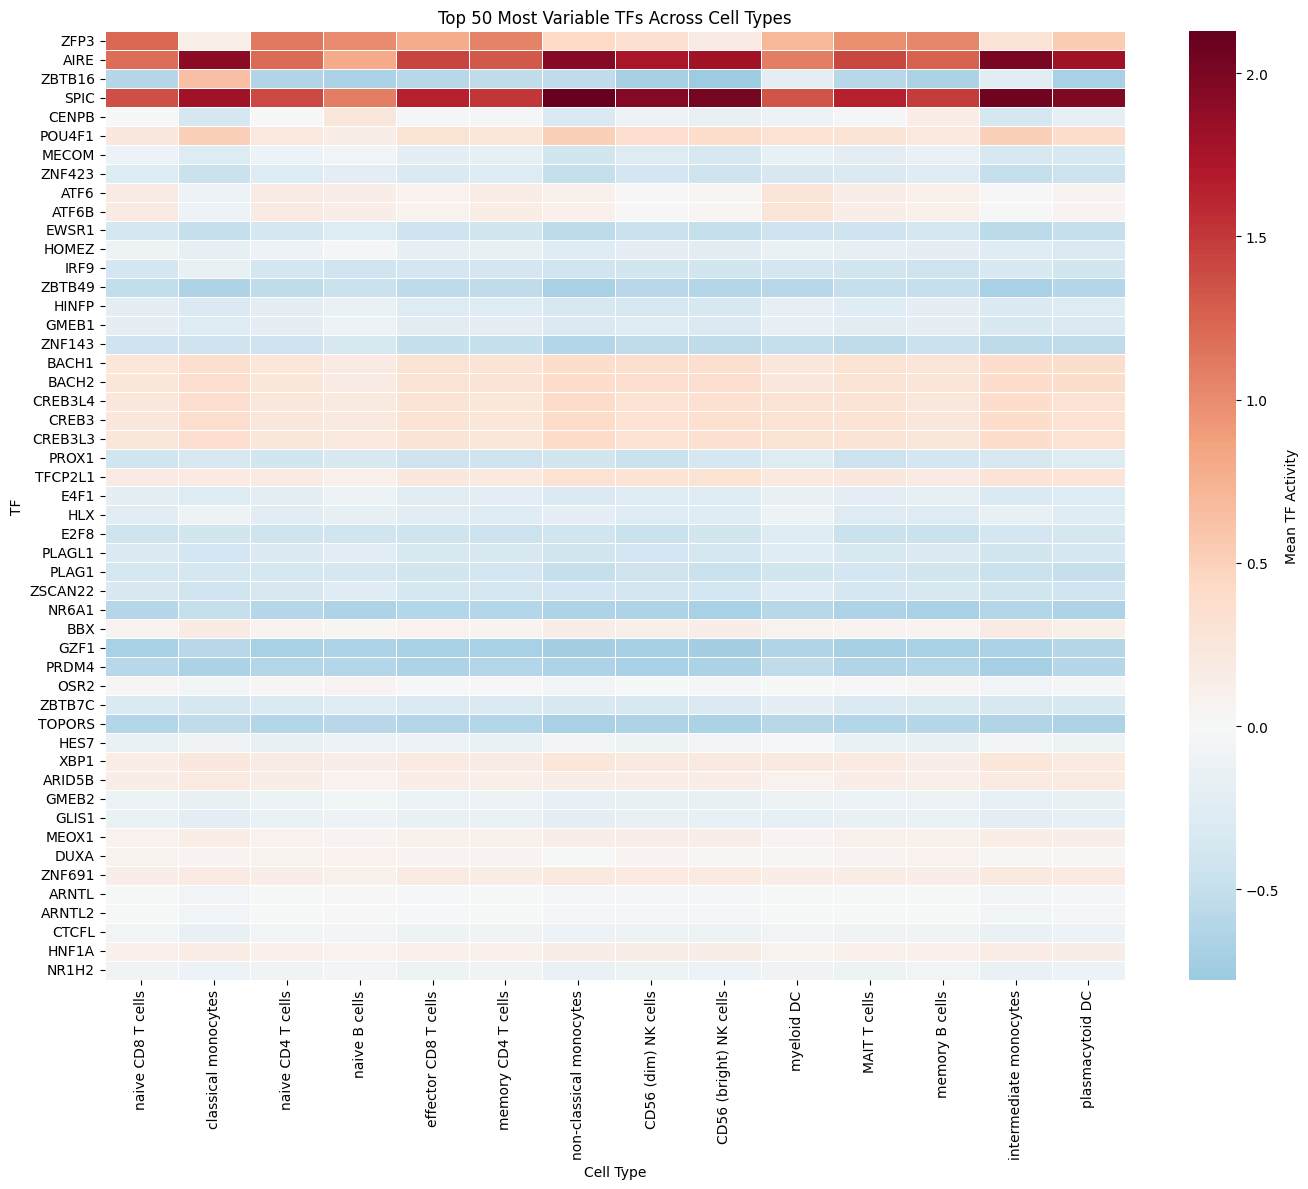

Showing 50 out of 451 total TFs


In [84]:
# Show top 50 most variable TFs
tf_variance = tf_by_celltype.var(axis=1).sort_values(ascending=False)
top_50 = tf_variance.head(50).index
tf_subset = tf_by_celltype.loc[top_50]

plt.figure(figsize=(14, 12))
sns.heatmap(tf_subset, cmap='RdBu_r', center=0, 
            cbar_kws={'label': 'Mean TF Activity'},
            linewidths=0.5, linecolor='white')
plt.title('Top 50 Most Variable TFs Across Cell Types')
plt.xlabel('Cell Type')
plt.ylabel('TF')
plt.tight_layout()
plt.savefig(f'{folder}/TF_activity_top50.png', dpi=300)
plt.show()

<Figure size 1400x1200 with 0 Axes>

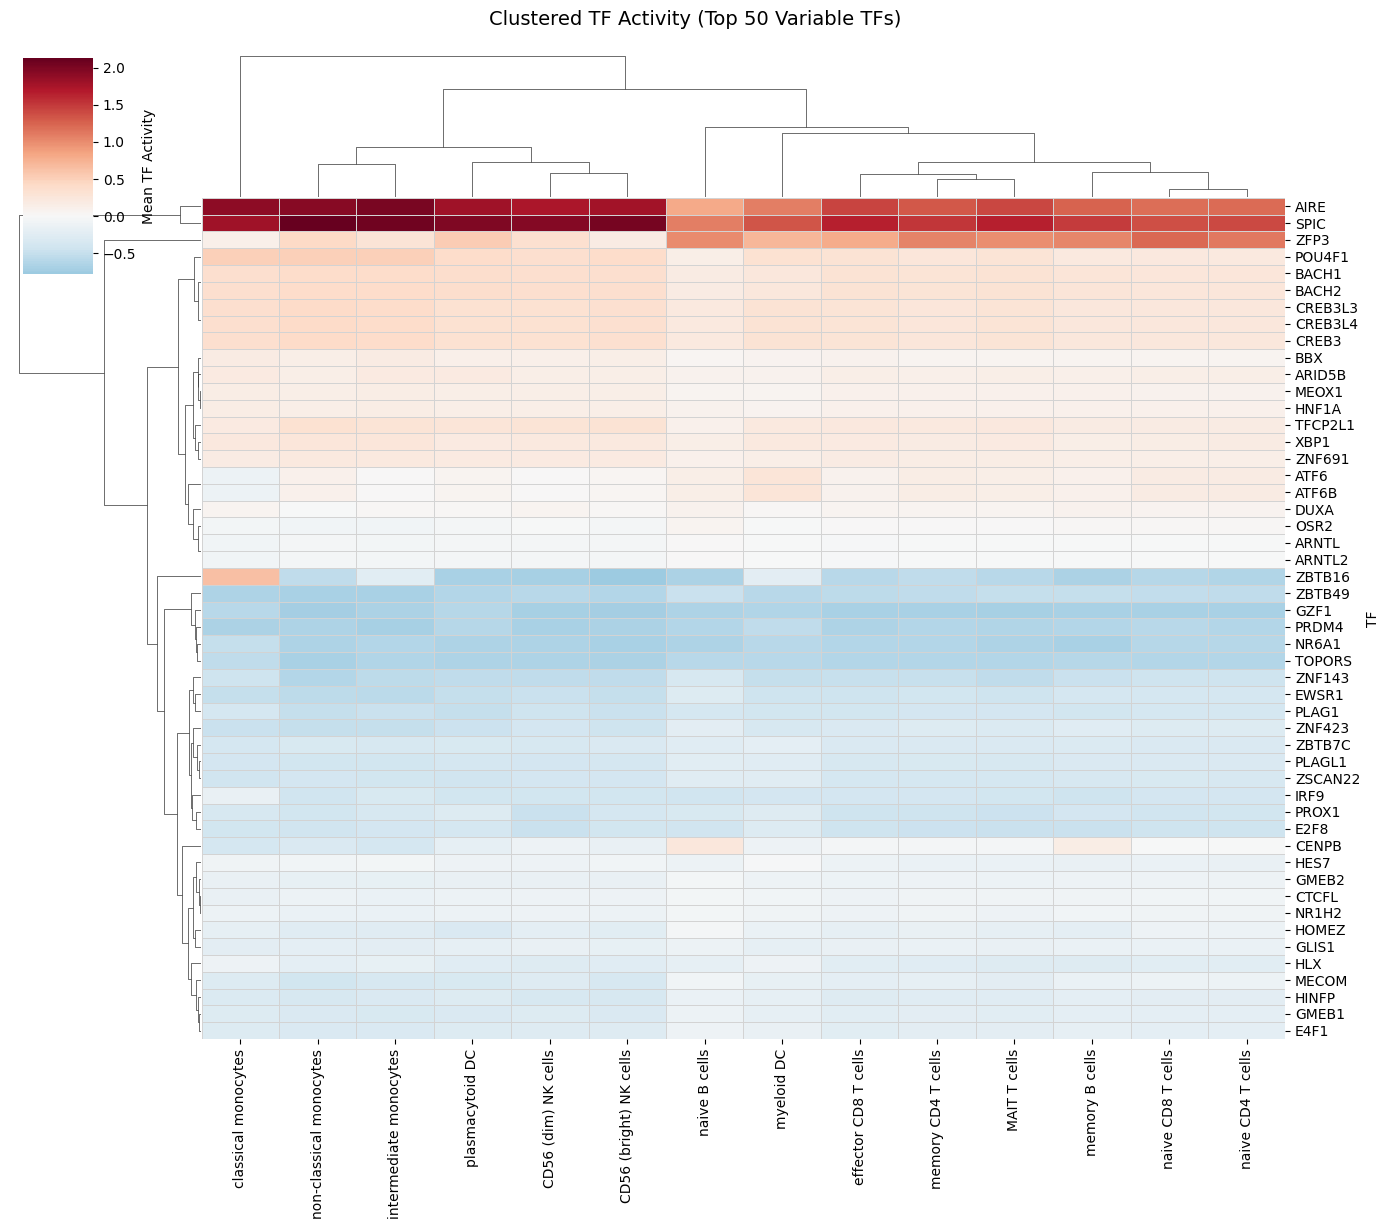

In [85]:
# Cluster both TFs and cell types
from scipy.cluster.hierarchy import linkage

plt.figure(figsize=(14, 12))
sns.clustermap(tf_subset, cmap='RdBu_r', center=0,
               figsize=(14, 12),
               cbar_kws={'label': 'Mean TF Activity'},
               row_cluster=True, col_cluster=True,
               linewidths=0.5, linecolor='lightgray',
               dendrogram_ratio=0.15)
plt.suptitle(f'Clustered TF Activity (Top {top_n} Variable TFs)', y=1.02, fontsize=14)
plt.savefig(f'{folder}/TF_activity_clustermap.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.4 Calculate TF activity

In [88]:
from LingerGRN.TF_activity import *

In [101]:
celltype='naive CD4 T cells'
outdir = f"Linger_output_{method}"
TF_activity = pd.read_csv("data/TF_activity.tsv")
TF_activity = TF_activity.set_index('Unnamed: 0')
TF_activity.index.name = 'TF'
TF_activity.head()

,CCAGACTCACTCAACA-1,ATAACGACATTAAACC-1,CACAATATCTCAATAG-1,GGTCCGTAGGACCGCT-1,AGCACAGCAGGTTATT-1,GCCTGCTGTTCACTGT-1,TCGTGCTTCTTGCTAT-1,TGCCATTGTAAAGCAA-1,GATAAAGGTTTGCTGT-1,GGTGATTTCAGCATTA-1,...,GAGGCTACATTGTGTG-1,CCGCAAATCATTTGTC-1,AGGTATTGTTAGTTGG-1,CGGGCTTAGTTATTCC-1,CGGCTAATCTAATCTC-1,TCCAGCAAGGCTATGT-1,CTATGATCACCATATG-1,CGTGCACAGCTAAAGG-1,AATGTCATCCTCATGC-1,CAAACTGGTACCTTAC-1
TF,,,,,,,,,,,,,,,,,,,,,
TCF7L2,-0.029040,-0.040135,-0.039345,-0.021546,-0.040753,-0.018468,-0.029377,-0.033576,-0.035982,-0.056058,...,-0.028309,-0.060670,-0.022660,-0.032213,-0.033987,-0.053914,-0.048176,0.013860,-0.015097,-0.043928
VSX2,0.027297,0.071264,0.037747,0.032604,0.060677,0.030666,0.027333,0.060823,0.025397,0.026179,...,0.038883,-0.002478,0.021141,0.012254,0.032310,0.033704,0.073999,0.063267,0.028462,0.028700
MEOX1,0.106411,0.289053,0.157333,0.070321,0.163943,0.059755,0.151740,0.177238,0.098505,0.131015,...,0.119945,0.032137,0.059937,0.010227,0.106880,0.144023,0.208047,0.028509,0.069430,0.089410
POU2F2,0.056845,0.144716,0.074603,0.038164,0.085375,0.020523,0.056933,0.115858,0.056030,0.049351,...,0.064838,-0.003624,0.034976,-0.014684,0.045760,0.065357,0.103885,0.020617,0.046818,0.042992
ATF6B,0.070839,-0.483745,-0.074752,0.261291,-0.082699,0.388646,-0.104637,-0.073895,0.174763,0.128728,...,0.007060,0.332330,0.136517,0.520019,0.138032,0.129438,-0.074482,-0.027962,0.270451,0.322388


T-test : find TFs that have significantly different activity in cell type of interest compared to all other cell types.

In [96]:
t_test_results=master_regulator(TF_activity,adata_RNA,celltype)
t_test_results

,t_stat,p_value,adj_p
TF,,,
TCF7L2,17.036425,1.947084e-64,1.033100e-63
VSX2,-17.132196,1.000000e+00,1.000000e+00
MEOX1,-15.528431,1.000000e+00,1.000000e+00
POU2F2,-17.644656,1.000000e+00,1.000000e+00
ATF6B,14.981766,1.792738e-50,6.970041e-50
...,...,...,...
TCF7L1,17.031220,2.122647e-64,1.113156e-63
NFIC,18.140028,1.253982e-72,1.315223e-71
E2F4,2.560995,5.226260e-03,8.540012e-03


In [126]:
# Sort by adjusted p-value to find significant TFs
significant = t_test_results[t_test_results['adj_p'] < 0.05].copy()
significant_sorted = significant.sort_values('t_stat', ascending=False)

print(f"Number of significant TFs: {len(significant)}")
print("\nTop 10 TFs ENRICHED in naive CD4 T cells:")
print(significant_sorted.head(10))


Number of significant TFs: 279

Top 10 TFs ENRICHED in naive CD4 T cells:
           t_stat        p_value          adj_p
TF                                             
NR4A1   24.569651  1.312893e-129  3.315210e-127
NR4A2   24.564762  1.470160e-129  3.315210e-127
OSR2    23.678044  8.656761e-121  1.301400e-118
TFAP4   23.143894  1.209149e-115  1.363316e-113
TWIST2  22.442391  4.792524e-109  4.032567e-107
TWIST1  22.437109  5.364834e-109  4.032567e-107
STAT3   22.219768  5.451042e-107  3.403290e-105
STAT4   22.214945  6.036879e-107  3.403290e-105
ZNF423  21.820033  2.408648e-103  1.207000e-101
ELK3    21.780327  5.503167e-103  2.232625e-101


In [110]:
a = pd.read_csv("data/PBMC_label.txt", sep='\t')
a['label'].value_counts()

label
classical monocytes        1848
memory CD4 T cells         1540
naive CD8 T cells          1471
naive CD4 T cells          1373
intermediate monocytes      626
CD56 (dim) NK cells         453
memory B cells              400
CD56 (bright) NK cells      391
non-classical monocytes     364
effector CD8 T cells        362
naive B cells               282
myeloid DC                  232
plasmacytoid DC             103
MAIT T cells                 98
Name: count, dtype: int64

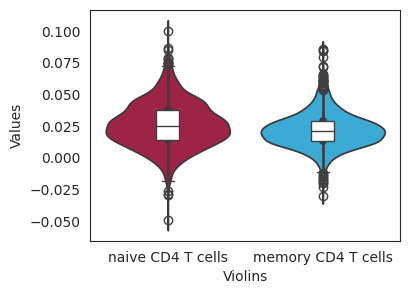

In [129]:
TFName='NR4A1'
datatype='activity'
celltype1 = 'naive CD4 T cells'
celltype2 = 'memory CD4 T cells'
save=False
box_comp(TFName,adata_RNA,celltype1,celltype2,datatype,TF_activity,save,outdir)

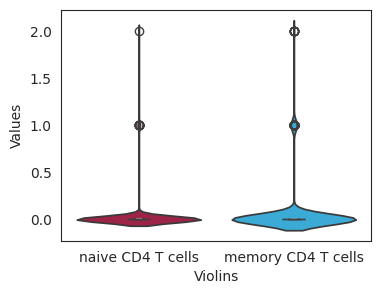

In [130]:
datatype='expression'
box_comp(TFName,adata_RNA,celltype1,celltype2,datatype,TF_activity,save,outdir)

### 4.4 Other files
- TF-RE : `cell_population_TF_RE_binding.txt`
- TF-RE binding split by chr : `chr*_cell_population_TF_RE_binding.txt`
- RE-TG : `cell_population_cis_regulatory.txt`
- TF-TG : `cell_population_trans_regulatory`
<br><br>
- `Region.bed` : [prior knowledge] list of regulatory elements (genomic coordinates)
- `Region_overlap_chr*.bed` : overlap of regions with chromosome-specific elements

In [70]:
!ls LINGER_output_baseline

 Region.bed
 Region_overlap_chr1.bed
 Region_overlap_chr10.bed
 Region_overlap_chr11.bed
 Region_overlap_chr12.bed
 Region_overlap_chr13.bed
 Region_overlap_chr14.bed
 Region_overlap_chr15.bed
 Region_overlap_chr16.bed
 Region_overlap_chr17.bed
 Region_overlap_chr18.bed
 Region_overlap_chr19.bed
 Region_overlap_chr2.bed
 Region_overlap_chr20.bed
 Region_overlap_chr21.bed
 Region_overlap_chr22.bed
 Region_overlap_chr3.bed
 Region_overlap_chr4.bed
 Region_overlap_chr5.bed
 Region_overlap_chr6.bed
 Region_overlap_chr7.bed
 Region_overlap_chr8.bed
 Region_overlap_chr9.bed
 Region_overlap_chrX.bed
'box_plot_ATF1_activity_naive CD4 T cells_Others.png'
'box_plot_ATF1_expression_naive CD4 T cells_Others.png'
'box_plot_FOXN1_activity_naive CD4 T cells_Others.png'
'box_plot_FOXN1_expression_naive CD4 T cells_Others.png'
'box_plot_NPAS2_activity_naive CD4 T cells_Others.png'
'box_plot_NPAS2_expression_naive CD4 T cells_Others.png'
'box_plot_SMAD3_activity_naive CD4 T cells_Others.png'
'box_plot_S

In [71]:
# Region.bed is the list of all regulatory elements (REs) = row in the df
df = pd.read_csv("LINGER_output_baseline/Region.bed", sep="\t", header=None)
df.columns = ["chrom", "start", "end"]
print(df.head(n=10))

# we can see that row 5 :                       	chr1 	629721 	630172
# appears in the cell below, overlapping with       chr1 	629715 	630715
df.shape

  chrom   start     end
0  chr1   10109   10357
1  chr1  180730  181630
2  chr1  191491  191736
3  chr1  267816  268196
4  chr1  586028  586373
5  chr1  629721  630172
6  chr1  633793  634264
7  chr1  777634  779926
8  chr1  816881  817647
9  chr1  819912  823500


(107174, 3)

In [72]:
# overlapping regulatory regions on chromosome 1
df = pd.read_csv("LINGER_output_baseline/Region_overlap_chr1.bed", sep="\t", header=None)
df.columns = ["chrom1", "start1", "end1", "chrom2", "start2", "end2"]
print(df.head())

# from 107174 REs to 78873 overlapping REs
df.shape

  chrom1  start1    end1 chrom2  start2    end2
0   chr1  629715  630715   chr1  629721  630172
1   chr1  630021  630050   chr1  629721  630172
2   chr1  630061  630170   chr1  629721  630172
3   chr1  633715  634715   chr1  633793  634264
4   chr1  633741  633810   chr1  633793  634264


(78873, 6)